# Billionaire Dataset - Wealth Analysis

This notebook explores and understands the patterns of wealth concentration, inequality, and the relationships between wealth and various socioeconomic factors.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import scipy.stats as stats
from scipy.stats import f_oneway
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.feature_engineering import create_features

## 1. Setup and Data Loading
Setting up visualizations style, display parameters, and loading data.

In [8]:
# Set visualization style
plt.style.use('ggplot')
sns.set_palette('Set2')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Load data
df = pd.read_csv('../data/processed/df_cleaned.csv')

# Apply feature engineering
df = create_features(df)

# Display basic structure about the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2591, 31)


,position,wealth,industry,full_name,age,country_of_residence,city_of_residence,source,citizenship,gender,birth_date,last_name,first_name,residence_state,residence_region,birth_year,birth_month,birth_day,cpi_country,cpi_change_country,gdp_country,g_tertiary_ed_enroll,g_primary_ed_enroll,life_expectancy,tax_revenue,tax_rate,country_pop,country_lat,country_long,continent,age_group
0,1,211000,Fashion & Retail,Bernard Arnault & family,74,France,Paris,LVMH,France,M,1949-03-05,Arnault,Bernard,No subdivisions info,No subdivisions info,1949,3,5,110.05,1.1,2715518274227,65.6,102.5,82.5,24.2,60.7,67059887,46.227638,2.213749,Europe,71-80
1,2,180000,Automotive,Elon Musk,51,United States,Austin,"Tesla, SpaceX",United States,M,1971-06-28,Musk,Elon,Texas,South,1971,6,28,117.24,7.5,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America,51-60
2,3,114000,Technology,Jeff Bezos,59,United States,Medina,Amazon,United States,M,1964-01-12,Bezos,Jeff,Washington,West,1964,1,12,117.24,7.5,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America,51-60
3,4,107000,Technology,Larry Ellison,78,United States,Lanai,Oracle,United States,M,1944-08-17,Ellison,Larry,Hawaii,West,1944,8,17,117.24,7.5,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America,71-80
4,5,106000,Finance & Investments,Warren Buffett,92,United States,Omaha,Berkshire Hathaway,United States,M,1930-08-30,Buffett,Warren,Nebraska,Midwest,1930,8,30,117.24,7.5,21427700000000,88.2,101.8,78.5,9.6,36.6,328239523,37.090240,-95.712891,North America,over 80


## 2. Basic Wealth Distribution Analysis
Analyzing and visualizing overall wealth distribution

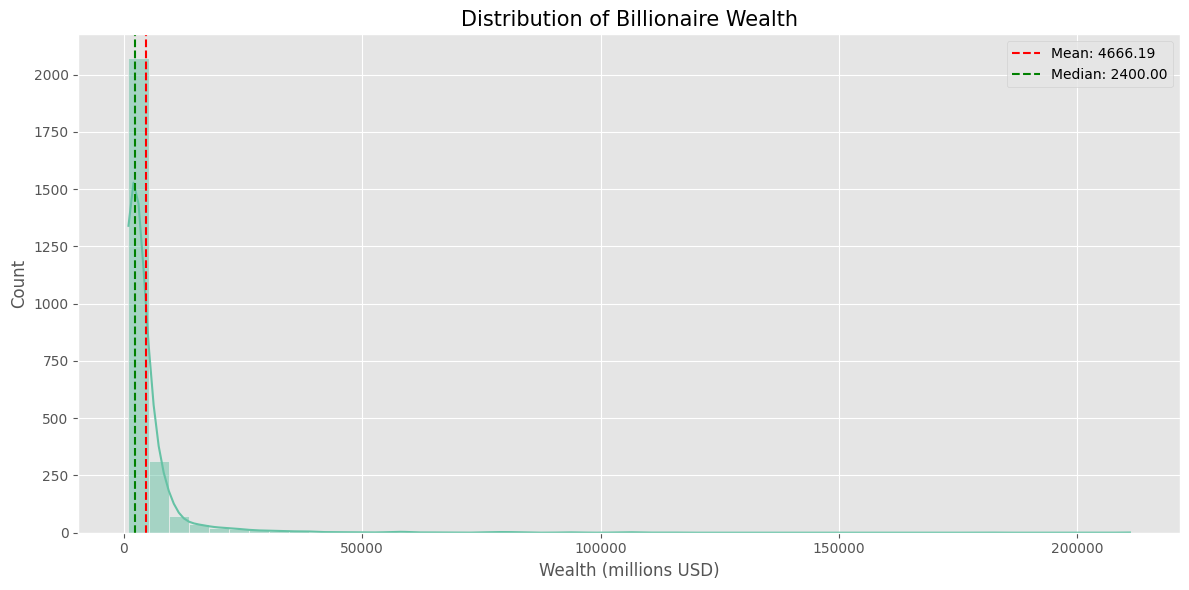

count      2591.000000
mean       4666.190660
std        9917.104258
min        1000.000000
25%        1500.000000
50%        2400.000000
75%        4300.000000
max      211000.000000
Name: wealth, dtype: float64

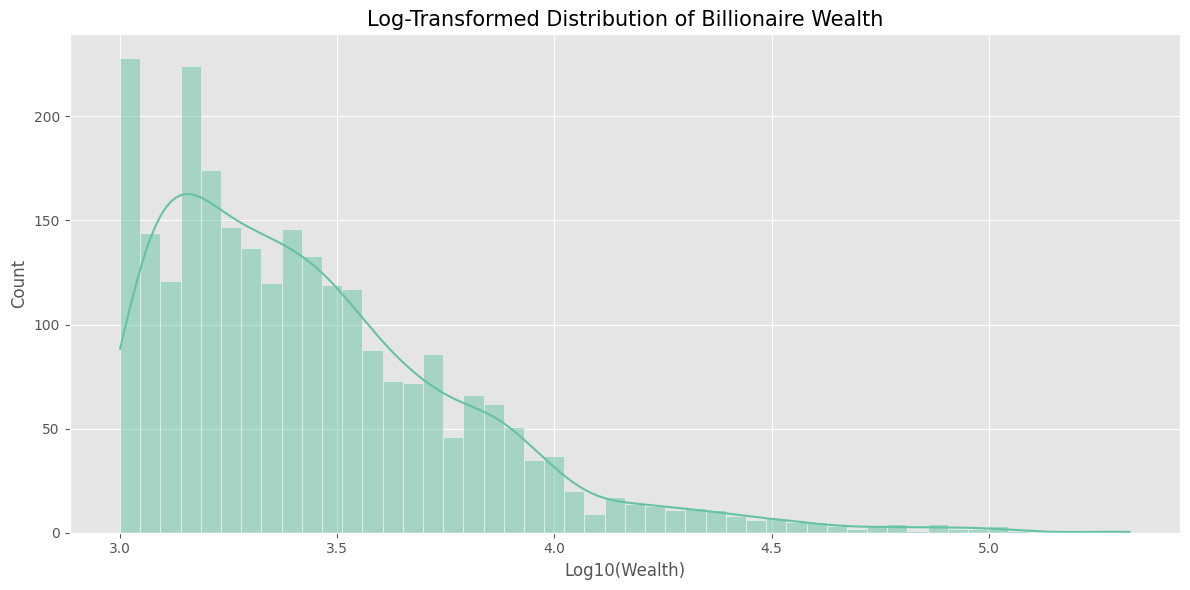

In [9]:
# Overview of wealth distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['wealth'], bins=50, kde=True)
plt.title('Distribution of Billionaire Wealth', fontsize=15)
plt.xlabel('Wealth (millions USD)')
plt.ylabel('Count')
plt.axvline(df['wealth'].mean(), color='red', linestyle='--', label=f'Mean: {df["wealth"].mean():.2f}')
plt.axvline(df['wealth'].median(), color='green', linestyle='--', label=f'Median: {df["wealth"].median():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Summary statistics
wealth_stats = df['wealth'].describe()
display(wealth_stats)

# Log-transformed wealth distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.log10(df['wealth']), bins=50, kde=True)
plt.title('Log-Transformed Distribution of Billionaire Wealth', fontsize=15)
plt.xlabel('Log10(Wealth)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Wealth Concentration Analysis
Explore wealth inequality within the billionaire population

,Percentile,Wealth Threshold (millions USD)
0,Top 0.1%,109870.0
1,Top 0.5%,76065.0
2,Top 1%,43110.0
3,Top 5%,13700.0
4,Top 10%,8000.0
5,Top 25%,4300.0
6,Top 50%,2400.0
7,Top 75%,1500.0
8,Top 90%,1200.0
9,Top 95%,1100.0


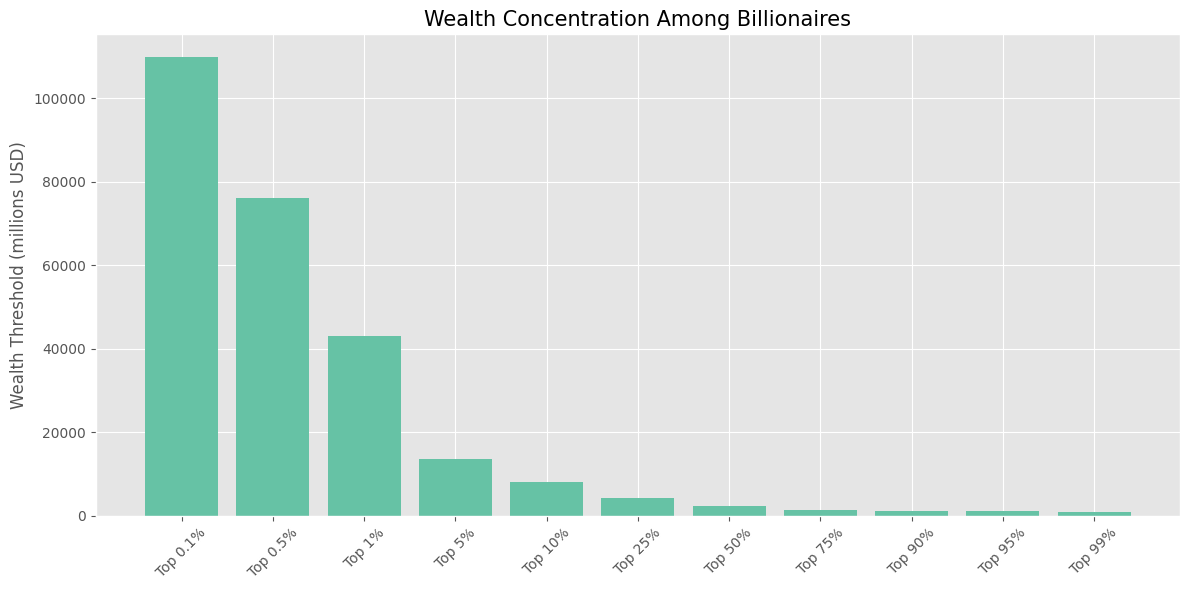

Gini coefficient among billionaires: 0.5504


In [13]:
# Wealth concentration - top percentiles
wealth_values = pd.to_numeric(df['wealth'], errors='coerce').dropna().values
wealth_percentiles = [0.1, 0.5, 1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = [100 - p for p in wealth_percentiles]
values = np.percentile(wealth_values, percentile_values)

# Create a dataframe for display
percentile_df = pd.DataFrame({
    'Percentile': [f'Top {p}%' for p in wealth_percentiles],
    'Wealth Threshold (millions USD)': values
})
display(percentile_df)

# Visualize wealth concentration
plt.figure(figsize=(12, 6))
plt.bar(percentile_df['Percentile'], percentile_df['Wealth Threshold (millions USD)'])
plt.title('Wealth Concentration Among Billionaires', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Wealth Threshold (millions USD)')
plt.tight_layout()
plt.show()

# Calculate Gini coefficient for billionaires
def gini(x):
    sorted_x = np.sort(x)
    n = len(sorted_x)
    # Calculate cumulative sum
    cum_sum = np.cumsum(sorted_x)
    # Calculate Gini coefficient
    return (n + 1 - 2 * np.sum((n + 1 - np.arange(1, n + 1)) * sorted_x) / cum_sum[-1]) / n

gini_coef = gini(wealth_values)
print(f"Gini coefficient among billionaires: {gini_coef:.4f}")

## 4. Demographic Analysis of Wealth
Analyzing wealth distribution by demographic factors

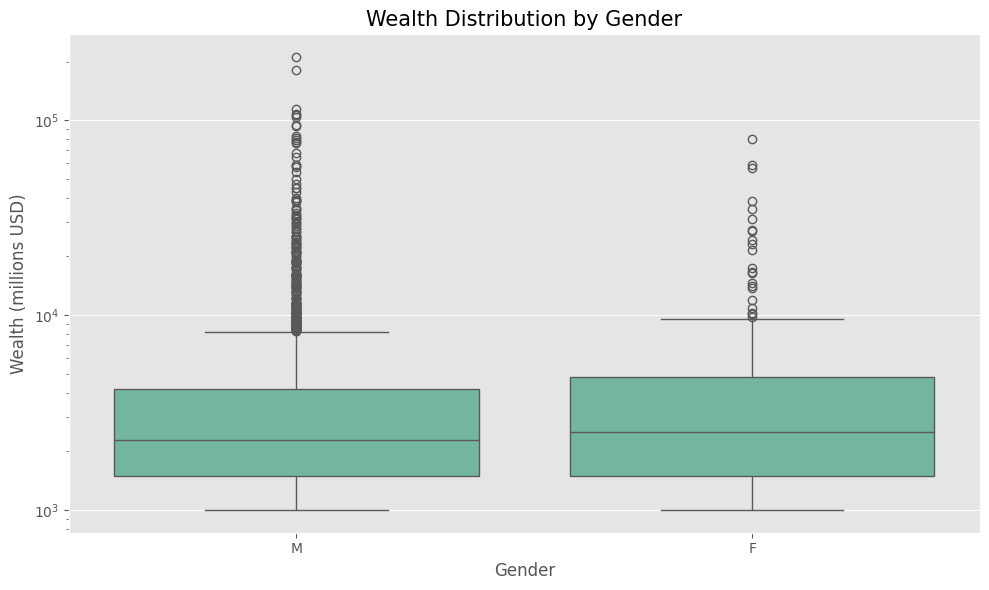

,Count,Percentage
gender,,
M,2268,87.533771
F,323,12.466229


T-test for wealth difference by gender: t=0.0845, p=0.9327
No statistically significant difference in wealth between genders


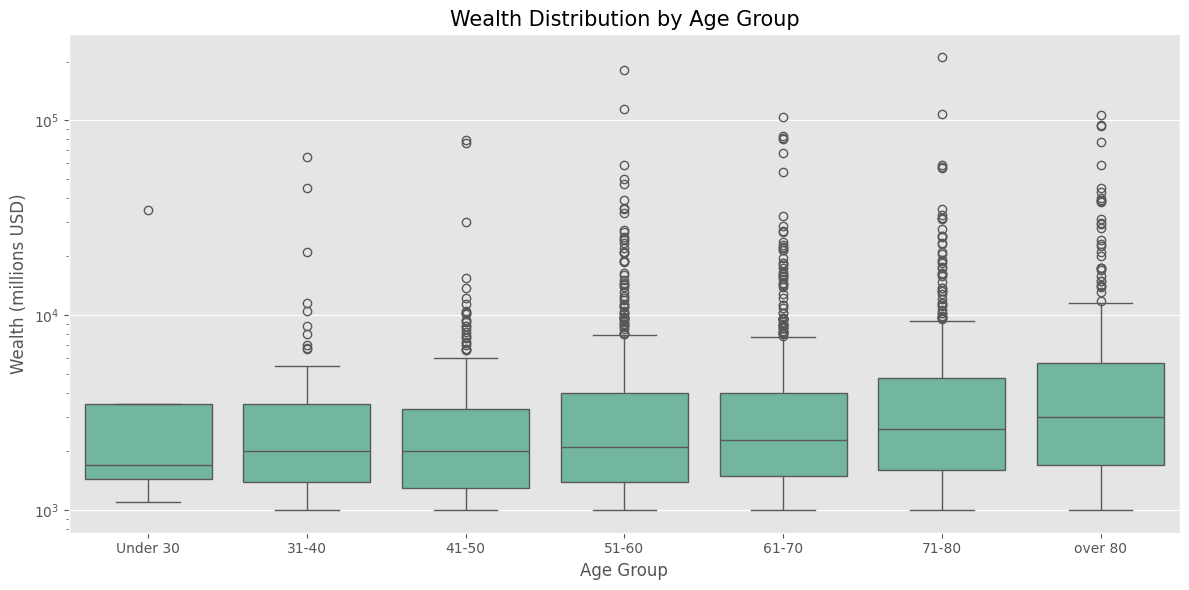

Correlation between age and wealth: r=0.0659, p=0.0008
There is a statistically significant correlation between age and wealth


In [14]:
# Wealth by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='wealth', data=df)
plt.title('Wealth Distribution by Gender', fontsize=15)
plt.xlabel('Gender')
plt.ylabel('Wealth (millions USD)')
plt.yscale('log') 
plt.tight_layout()
plt.show()

# Count and percentage by gender
gender_counts = df['gender'].value_counts()
gender_pct = gender_counts / len(df) * 100
gender_summary = pd.DataFrame({
    'Count': gender_counts,
    'Percentage': gender_pct
})
display(gender_summary)

# Statistical test: wealth difference by gender
male_wealth = df[df['gender'] == 'M']['wealth']
female_wealth = df[df['gender'] == 'F']['wealth']
t_stat, p_val = stats.ttest_ind(male_wealth, female_wealth, equal_var=False)
print(f"T-test for wealth difference by gender: t={t_stat:.4f}, p={p_val:.4f}")
if p_val < 0.05:
    print("There is a statistically significant difference in wealth between genders")
else:
    print("No statistically significant difference in wealth between genders")

# Wealth by age group
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='wealth', data=df)
plt.title('Wealth Distribution by Age Group', fontsize=15)
plt.xlabel('Age Group')
plt.ylabel('Wealth (millions USD)')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Statistical test: wealth correlation with age
corr, p_val = stats.pearsonr(df['age'].dropna(), df['wealth'].dropna())
print(f"Correlation between age and wealth: r={corr:.4f}, p={p_val:.4f}")
if p_val < 0.05:
    print("There is a statistically significant correlation between age and wealth")
else:
    print("No statistically significant correlation between age and wealth")